# Trabajo Práctico 2: Filtrado lineal óptimo
Pablo González Leiro

Septiembre 2022

In [82]:
import scipy
from scipy.fft import fft, fftshift, fftfreq
import numpy as np
from matplotlib import pyplot as plt
from playsound import playsound
import sounddevice
import soundfile

## Setup
<a href="https://productz.com/en/logitech-x50/p/KZ6Z">Parlante Logitech X50</a>

<table>
<tr><td colspan=2>Especificaciones Logitech X50</td></tr>
<tr><td>Canales</td><td>1</td></tr>
<tr><td>Frecuencia más baja</td><td>130 Hz</td></tr>
<tr><td>Frecuencia más alta</td><td>20000 Hz</td></tr>
<tr><td>Potencia RMS</td><td>3W</td></tr>
<tr><td>Potencia pico</td><td>3W</td></tr>
</tr>
</table>

Las grabaciones fueron hechas usando un iPhone XS y la aplicación [Auphonic Recorder](https://apps.apple.com/us/app/auphonic-recorder/id1081792712), con la que se configuró:
- iPhone Microphone (Bottom). La otras opciones eran Front y Back.
- Formato CAF (Core Audio Format), que es similar a WAV (Waveform Audio Format)
- Frecuencia de muestreo 48000 Hz
- 1 Canal (Mono)
- 16 bits de precisión

Las grabaciones luego fueron convertidas de .caf a .wav usando el comando:
```
ffmpeg -i input.caf output.wav
```

In [83]:
""" Signal parameters """
fs = 48000
n_sec = 10
amplitude = np.iinfo(np.int16).max

""" Plot parameters """
figsize = (3.2, 2.4)

In [84]:
def periodogram(x, N=2**20, Fs=fs):
    sp = fftshift(fft(x=x, n=N))
    freq = fftshift(fftfreq(n=N, d=1/Fs))
    Pxx = np.abs(sp)**2 / N
    return freq, Pxx

def periodogram_averaging(x, N, L, D):
    periodograms = []
    i = 0
    while i < (N-D):
        window = scipy.signal.windows.tukey(L, alpha=0.5, sym=True)
        data = x[i:i+L]
        data_windowed = np.multiply(window, data)
        freq, Pxx = periodogram(x=data_windowed, N=L)
        periodograms.append(Pxx)
        i = i + L - D
    K = len(periodograms)
    y = np.array([np.array(xi) for xi in periodograms])
    mean_periodogram = np.mean(a=y, axis=0)
    return freq, mean_periodogram, K

def plot_audio(
    x: np.array,
    fs: int, freq: np.array,
    Pxx: np.array,
    title: str,
    xlim: tuple = (0,10*fs)
    ) -> plt.Figure:

    fig = plt.figure(num=title, figsize=(10,3.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(x)
    ax1.set_xlim(*xlim)
    ticks = np.linspace(xlim[0], xlim[1], 6)
    ax1.set_xticks(
        ticks=ticks,
        labels=[f"{i/fs}" for i in ticks]
    ) 
    #ax1.set_yticks(ticks=[-2**15,0,2**15-1], labels=[-2**15,0,2**15-1])
    ax1.set_title(title)
    ax1.set_ylabel("Amplitude @ 16 bits")
    ax1.set_xlabel("Time [s]")
    
    n = len(freq)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.loglog(freq[n//2:], Pxx[n//2:], nonpositive='clip')
    ax2.set_title(f"PSD {title}")
    ax2.set_xlim((2, fs//2))
    ax2.set_xticks(ticks=[2,20,200,2000,20000], labels=[2,20,200,2000,20000])
    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("Power [W]")
    for line in [130, 20000]:
        ax2.axvline(line, linestyle="dotted", color="k")
    
    plt.close()
    return fig

## 1. Generar las excitaciones $x_j(n)$ y grabar las señales $u_j(n)$

Para cada señal generada, se hizo una grabación manteniendo el setup inicial. Luego se realizó la conversión CAF a WAV, para poder trabajar con los datos en Python.

### 1. Señal de voz

Para cubrir el espectro audible lo mejor posible, elegí un audio con varias voces, masculinas y femeninas.

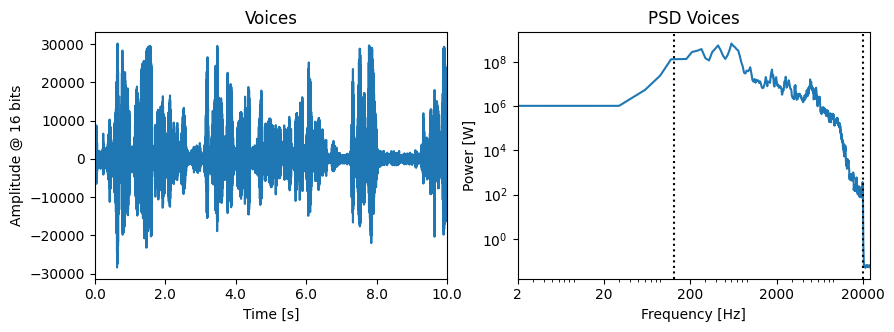

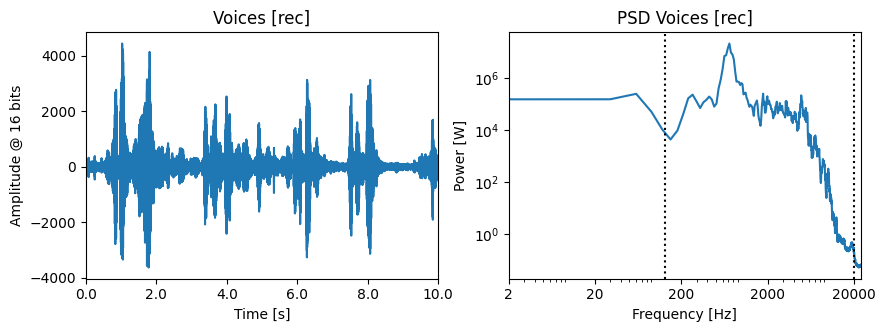

In [85]:
""" Original audio """
rate, data = scipy.io.wavfile.read(filename="audio/original/voices.wav")
offset = 20000
x1 = data[offset:offset+rate*10,1] # right

# Periodograma
N = len(x1)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=x1, N=N, L=L, D=L//2)

scipy.io.wavfile.write("audio/original/voices_right.wav", rate, x1.astype(np.int16))
#sounddevice.play(x, rate)

figx1 = plot_audio(x1, rate, freq, Pxx, "Voices")


""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recording/voices_mic.wav")
offset = 47000 # a ojo
y1 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y1)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=y1, N=N, L=L, D=L//2)
figy1 = plot_audio(x=y1, fs=rate_mic, freq=freq, Pxx=Pxx, title="Voices [rec]")

display(figx1, figy1)

### 2. Señal de música

Elegí un fragmento solo con instrumentación (sin voz humana) ya que tenía la intuición de que así generaría un resultado distinto al del caso anterior. Además, investigué un poco sobre los distintos géneros musicales y su contenido espectral. Encontré que géneros como el Jazz tienden a tener máyor potencia en frecuencias medias, mientras que otros géneros como el hip-hop, el rock y el pop suelen tener máyor contenido en frecuencias bajas (<150Hz) y altas (>5000Hz).

Como mi parlante funciona entre 130 y 20000 Hz opté por usar un fragmento de Jazz, de la canción "New York, New York".

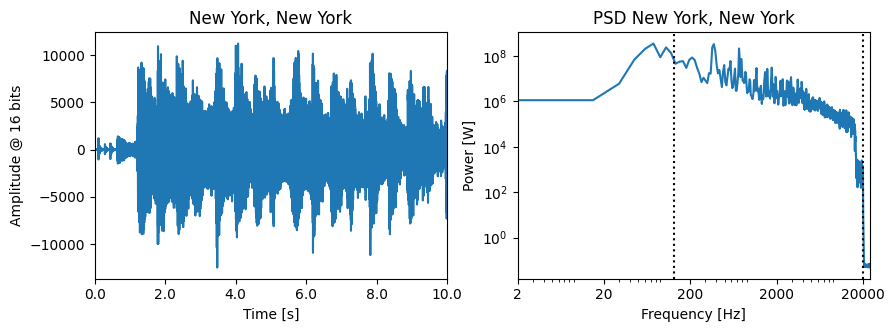

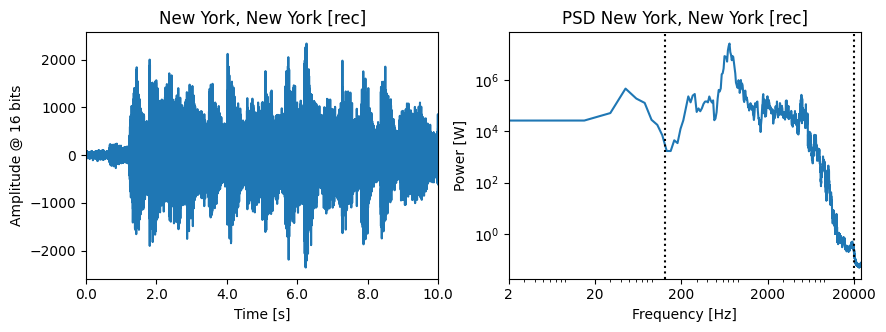

In [86]:
""" Original audio """
rate, data = scipy.io.wavfile.read(filename="audio/original/newyork.wav")
offset = 20000
x2 = data[offset:offset+rate*10,1] # right s

# Periodograma
N = len(x2)
L = N // 150
freq, Pxx, K = periodogram_averaging(x=x2, N=N, L=L, D=L//2)

scipy.io.wavfile.write("audio/original/newyork_right.wav", rate, x2.astype(np.int16))
#sounddevice.play(x, rate)

ob = soundfile.SoundFile("audio/original/newyork.wav")
ob.subtype

figx2 = plot_audio(x2, rate, freq, Pxx, "New York, New York")


""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recording/newyork_mic.wav")
offset = 66000 # a ojo
y2 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y2)
L = N // 150
freq, Pxx, K = periodogram_averaging(x=y1, N=N, L=L, D=L//2)
figy2 = plot_audio(x=y2, fs=rate_mic, freq=freq, Pxx=Pxx, title="New York, New York [rec]")

display(figx2, figy2)

### 3. Square wave

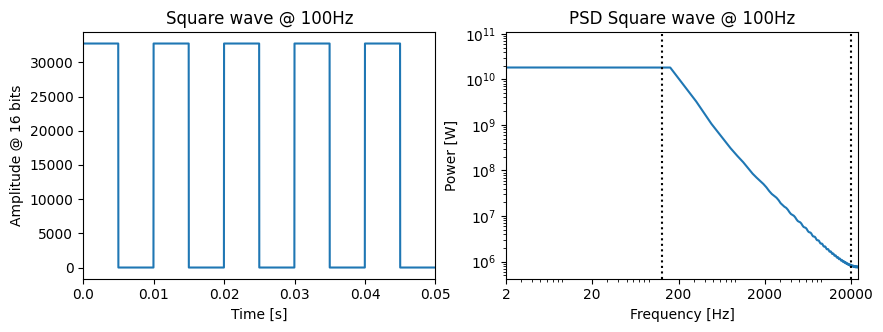

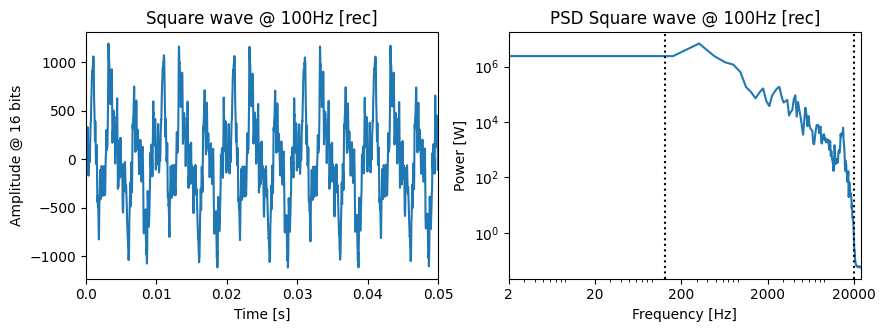

In [87]:
f = 100
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x3 = amplitude//2 *( 1 + scipy.signal.square(2 * np.pi * f * t) )
scipy.io.wavfile.write("audio/original/square_wave.wav", fs, x3.astype(np.int16))

# Periodograma
N = len(x3)
L = N // 1600
freq, Pxx, K = periodogram_averaging(x=x3, N=N, L=L, D=L//2)
figx3 = plot_audio(x3[:fs//20], fs, freq, Pxx, f"Square wave @ {f}Hz", xlim=(0,fs//20))

""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recording/square_wave_mic.wav")
offset = 60000 # a ojo
y3 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y3)
L = N // 1600
freq, Pxx, K = periodogram_averaging(x=y3, N=N, L=L, D=L//2)
figy3 = plot_audio(x=y3[5*fs:5*fs+fs//20], fs=rate_mic, freq=freq, Pxx=Pxx, title=f"Square wave @ {f}Hz [rec]", xlim=(0, fs//20))

display(figx3, figy3)

### 4. Barrido lineal en frecuencia

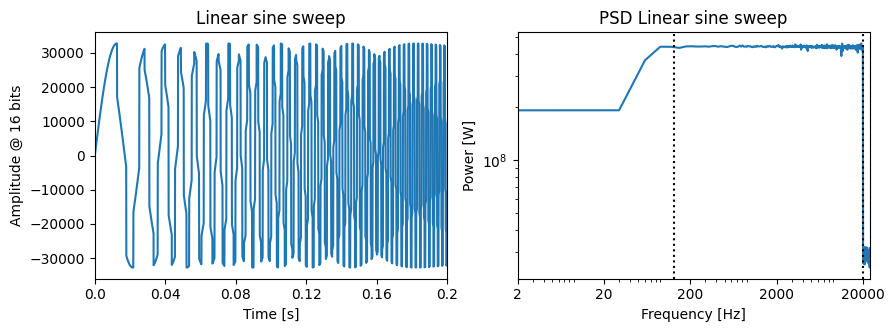

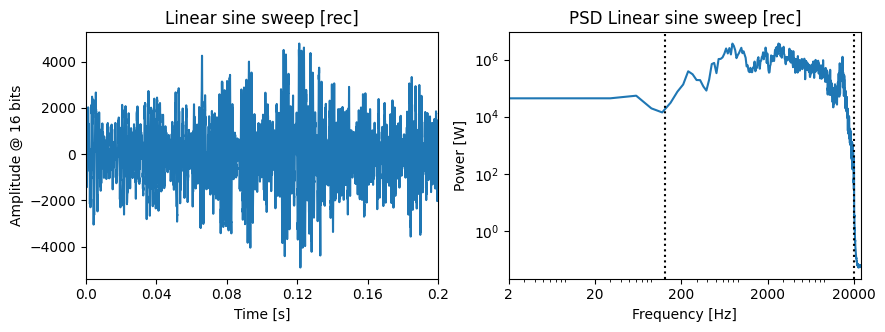

In [93]:
f0 = 20
f1 = 20000
T = n_sec
k = (f1 - f0) / T
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x4 = np.iinfo(np.int16).max * np.sin( 2*np.pi*f0*t + 2*np.pi*k*t**2//2  )
scipy.io.wavfile.write("audio/original/linear_sine_sweep.wav", fs, x4.astype(np.int16))

# Periodograma
N = len(x4)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=x4, N=N, L=L, D=L//2)

figx4 = plot_audio(x4[:fs//5], fs, freq, Pxx, title="Linear sine sweep", xlim=(0,fs//5))

""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recording/linear_sine_sweep_mic.wav")
offset = 75000 # a ojo
y4 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y4)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=y4, N=N, L=L, D=L//2)
figy4 = plot_audio(x=y4[0:fs//5], fs=rate_mic, freq=freq, Pxx=Pxx, title="Linear sine sweep [rec]", xlim=(0,fs//5))


display(figx4, figy4)

### 5. Barrido exponencial en frecuencia

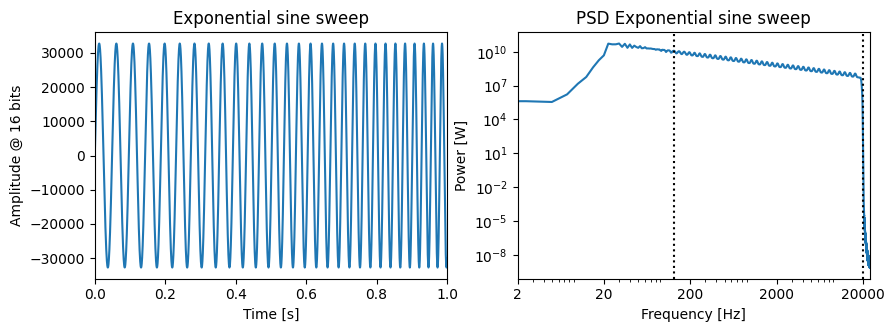

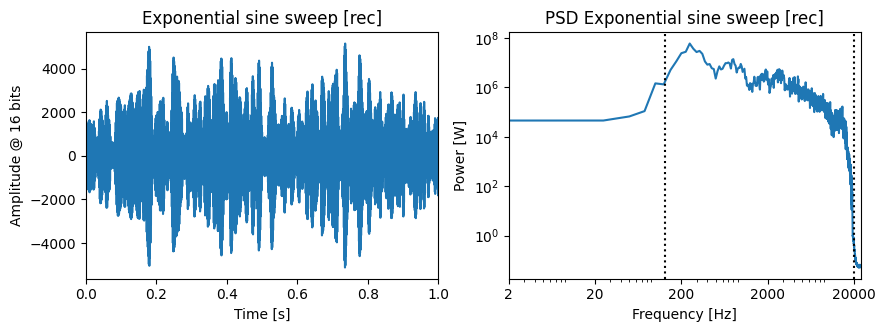

In [89]:
f0 = 20
f1 = 20000
T = n_sec
k = (f1 / f0) ** (1 / T)
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x5 = np.iinfo(np.int16).max * np.sin( 2*np.pi*f0 * (k**t - 1) / (np.log(k)) )
scipy.io.wavfile.write("audio/original/exp_sine_sweep.wav", fs, x.astype(np.int16))

# Periodograma
N = len(x5)
L = N // 25
freq, Pxx, K = periodogram_averaging(x=x5, N=N, L=L, D=L//2)

figx5 = plot_audio(x5[:fs], fs, freq, Pxx, title="Exponential sine sweep", xlim=(0,fs))

""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recording/exp_sine_sweep_mic.wav")
offset = 100000 # a ojo
y5 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y5)
L = N // 250
freq, Pxx, K = periodogram_averaging(x=y5, N=N, L=L, D=L//2)
figy5 = plot_audio(x=y5[5*fs:6*fs], fs=rate_mic, freq=freq, Pxx=Pxx, title="Exponential sine sweep [rec]", xlim=(0,fs))


display(figx5, figy5)

### Ruido blanco gaussiano de media cero

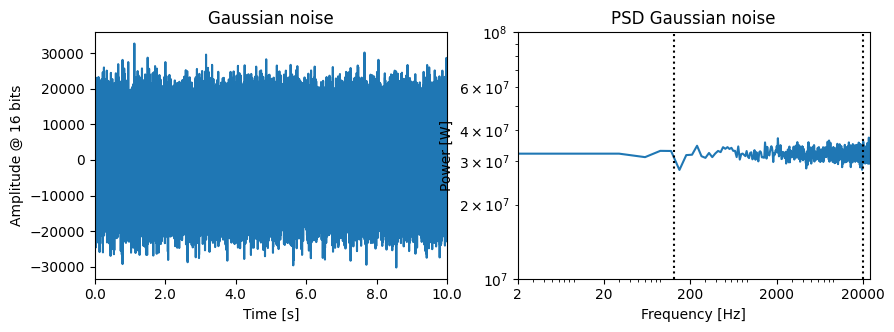

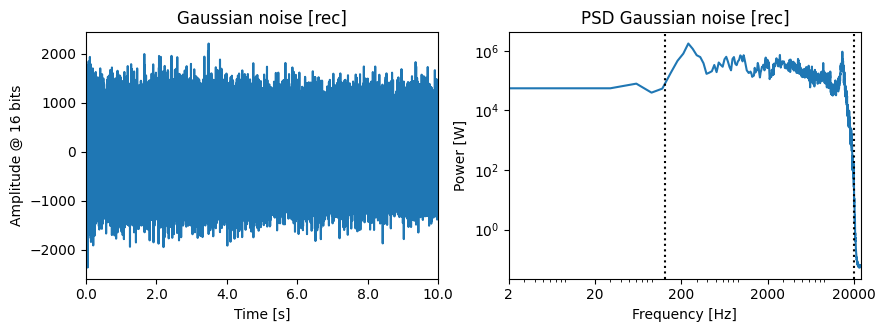

In [90]:
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x6 = np.random.normal(loc=0, scale=1, size=n_sec*fs)
x6 = amplitude * x6 / np.max(x6)
scipy.io.wavfile.write("audio/original/gaussian_noise.wav", fs, x6.astype(np.int16))
# Periodograma
N = len(x6)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=x6, N=N, L=L, D=L//2)

figx6 = plot_audio(x6, fs, freq, Pxx, title="Gaussian noise")
figx6.axes[1].set_ylim(10**7,10**8)


""" Audio recorded with the microphone """
rate_mic, data_mic = scipy.io.wavfile.read(filename="audio/recording/gaussian_noise_mic.wav")
offset = 90000 # a ojo
y6 = data_mic[offset:offset+10*rate_mic]

# Periodograma
N = len(y6)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=y6, N=N, L=L, D=L//2)
figy6 = plot_audio(x=y6, fs=rate_mic, freq=freq, Pxx=Pxx, title="Gaussian noise [rec]")


display(figx6, figy6)


## 2. Opinión: ¿cuál excitación dará la mejor estimación de h(n)?

En primer lugar, descarto la onda cuadrada. Intuyo que por tener cambios muy rápidos, la señal de sonido física no puede ser emitida de forma precisa por el parlante ni recibida correctamente por el micrófono. Eso explicaría por qué el espectro de la señal grabada es tan distinto de respecto de la onda cuadrada original.

Los barridos tienen la ventaja de no tener variaciones tan bruscas y de tener un espectro bastante plano en el rango audible. El barrido exponencial recorre todas las frecuencias de una forma que es más congruente con el funcionamiento natural del oído humano, por lo tanto, se podría pensar que tal excitación logrará captar mejor los artefactos del ambiente que hacen a la percepción humana del sonido. En ese sentido, creo que la estimación de h(n) dada por el barrido exponencial será mejor que la obtenida con el barrido lineal.

El ruido blanco gaussiano también es plano y además podemos observar que el espectro de la señal grabada es mucho más similar a la original que los casos de barrido exponencial y lineal, donde se observa una caída más pronunciada entre 2000 y 20000 Hz. De hecho, sucede lo mismo en las señales de voz y de música.
Con lo visto hasta acá, y siendo que la identificación de sistemas actúa para maximizar la correlación entre la señal estimada y la señal deseada, yo espero que el ruido blanco gaussiano me dé la mejor estimación de h(n).

## 3. J

In [ ]:
def calc_optimum_filter(sigma2, R, p):
    '''
    Calcula el filtro lineal óptimo
    
    sigma2: energía de la señal de entrada
    R: matriz de autocorrelación
    p: vector de correlación cruzada
    '''
    wo = np.dot(np.linalg.inv(R), p)
    
    Jo = sigma2 - p.dot(wo)
    
    return (wo, Jo)

In [119]:
R = np.cov(x4, x4, rowvar=False)
R.shape

(2, 2)

Porqué forward y no filtrado FIR??